In [1]:
from typing import Any
import awkward as ak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from tqdm import tqdm
import xgboost
import catboost
import uproot
import coffea
import hist
import vector
import copy
vector.register_awkward()

/afs/cern.ch/user/n/nmangane/.local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
#help(train_test_split)

In [3]:
from coffea import processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema

In [4]:
era = "2018"
channel = "ElMu"
tttt = NanoEventsFactory.from_root(
    f"/eos/home-n/nmangane/analysis/February10_Baseline_{era}/Nano/{channel}/{era}___tttt.root",
    schemaclass=BaseSchema, 
    entry_stop=None
).events()
#tttt = tttt[tttt.dsid1k < 50]
ttlight = NanoEventsFactory.from_root(
    f"/eos/home-n/nmangane/analysis/February10_Baseline_{era}/Nano/{channel}/{era}___ttother_DL-GF_fr.root", 
    schemaclass=BaseSchema, 
    entry_stop=None
).events()
#ttlight = ttlight[ttlight.dsid1k < 50] #Need to recreate this dataset... le sigh
ttbb = NanoEventsFactory.from_root(
    f"/eos/home-n/nmangane/analysis/February10_Baseline_{era}/Nano/{channel}/{era}___ttbb_DL-GF_fr.root", 
    schemaclass=BaseSchema, 
    entry_stop=None
).events()
#mumu_tttt = NanoEventsFactory.from_root(
#    "/eos/home-n/nmangane/analysis/February10_Baseline_2018/Nano/MuMu/2018___tttt.root", schemaclass=BaseSchema, entry_stop=10000
#).events()

In [5]:
events = tttt

In [6]:
bTagWorkingPointDict = dict()
bTagWorkingPointDict[False] = {
        "2016": {
            "DeepCSV": {"L": 0.2217, "M": 0.6321, "T": 0.8953, "Var": "btagDeepB"},
            "DeepJet": {"L": 0.0614, "M": 0.3093, "T": 0.7221, "Var": "btagDeepFlavB"},
        },
        "2017": {
            "CSVv2": {"L": 0.5803, "M": 0.8838, "T": 0.9693, "Var": "btagCSVV2"},
            "DeepCSV": {"L": 0.1522, "M": 0.4941, "T": 0.8001, "Var": "btagDeepB"},
            "DeepJet": {"L": 0.0521, "M": 0.3033, "T": 0.7489, "Var": "btagDeepFlavB"},
        },
        "2018": {
            "DeepCSV": {"L": 0.1241, "M": 0.4184, "T": 0.7527, "Var": "btagDeepB"},
            "DeepJet": {"L": 0.0494, "M": 0.2770, "T": 0.7264, "Var": "btagDeepFlavB"},
        },  # Non-UL WPs
    }
bTagWorkingPointDict[True] = {
        "2016preVFP": {
            "DeepCSV": {"L": 0.2027, "M": 0.6001, "T": 0.8819, "Var": "btagDeepB"},
            "DeepJet": {"L": 0.0508, "M": 0.2598, "T": 0.6502, "Var": "btagDeepFlavB"},
        },
        "2016postVFP": {
            "DeepCSV": {"L": 0.1918, "M": 0.5847, "T": 0.8767, "Var": "btagDeepB"},
            "DeepJet": {"L": 0.0480, "M": 0.2489, "T": 0.6377, "Var": "btagDeepFlavB"},
        },
        "2017": {
            "DeepCSV": {"L": 0.1355, "M": 0.4506, "T": 0.7738, "Var": "btagDeepB"},
            "DeepJet": {"L": 0.0532, "M": 0.3040, "T": 0.7476, "Var": "btagDeepFlavB"},
        },
        "2018": {
            "DeepCSV": {"L": 0.1208, "M": 0.4168, "T": 0.7665, "Var": "btagDeepB"},
            "DeepJet": {"L": 0.0490, "M": 0.2783, "T": 0.7100, "Var": "btagDeepFlavB"},
        },  # UL WPs
    }
scale_systematic = "nom"
#the_var = bTagWorkingPointDict[False][era]["DeepJet"]["Var"]
the_var = f"FTAJet__{scale_systematic}_DeepJetB"
the_wp = bTagWorkingPointDict[False][era]["DeepJet"]["M"]

In [7]:
len(tttt), len(ttlight), len(ttbb)

(208181, 744126, 24965)

In [8]:
model_vLF = None
model_vHF = None
model_nested_layer1 = None
model_nested_layer2 = None

In [9]:
def get_features(events, 
                 is_mc=True,
                 remove_negative_weights=False, 
                 normalize_weights=False,
                 scale_systematic="nom", 
                 wgt_systematic="nom", 
                 e_filter=lambda e: e.dsid1k < 500,
                 named_models_features=None
                ):
    ret = dict()
    mus = ak.zip({"pt": events.FTAMuon_pt, 
                  "eta": events.FTAMuon_eta, 
                  "phi": events.FTAMuon_phi, 
                  "mass": events.FTAMuon_mass,
                  "loose": events.FTAMuon_looseId,
                  #"isolation": (events.FTAMuon_pfIsoId >= 4)
                 },
                 with_name="Momentum4D"
                )
    els = ak.zip({"pt": events.FTAElectron_pt, 
                  "eta": events.FTAElectron_eta, 
                  "phi": events.FTAElectron_phi, 
                  "mass": events.FTAElectron_mass,
                  "loose": (events.FTAElectron_cutBased >= 2),
                  #"isolation": (don't have it... le sigh)
                 },
                 with_name="Momentum4D"
                )
    jets = ak.zip({"pt": getattr(events, f"FTAJet__{scale_systematic}_pt"), 
                  "eta": getattr(events, f"FTAJet__{scale_systematic}_eta"), 
                  "phi": getattr(events, f"FTAJet__{scale_systematic}_phi"), 
                  "mass": getattr(events, f"FTAJet__{scale_systematic}_mass"),
                  "btag": getattr(events, f"FTAJet__{scale_systematic}_DeepJetB"),
                 },
                 with_name="Momentum4D"
                )

    selection = (
        (ak.num(getattr(events, f"FTAJet__{scale_systematic}_pt"), axis=1) >= 4) 
        & (ak.sum(getattr(events, f"FTAJet__{scale_systematic}_pt"), axis=1) >= 500)
        & (np.abs(getattr(events, f"FTAMuon_InvariantMass") - 91) > 15)
        & (
            (getattr(events, f"FTAMuon_InvariantMass") < 0)
            | (getattr(events, f"FTAMuon_InvariantMass") > 20)
        )
        & (
            (ak.num(els, axis=1) + ak.num(mus, axis=1)) == 2
        )
        & (getattr(events, f"nMediumDeepJetB__{scale_systematic}") > 1)
    )
    if is_mc:
        if remove_negative_weights:
            selection = selection & (getattr(events, f"wgt___{wgt_systematic}") > 0)
    if e_filter:
        selection = selection & (e_filter(events))
        
    events = events[selection]
    print("mean dsid1k", np.mean(events.dsid1k))
    mus = mus[selection]
    els = els[selection]
    jets = jets[selection]
    bsrt = ak.argsort(jets.btag, axis=1, ascending=False)
    at_least_three_jets = ak.num(jets, axis=1) > 2
    fallback = -0.1 * ak.ones_like(at_least_three_jets)
    
    ret["MET_pt"] = ak.to_numpy(getattr(events, f"FTAMET__{scale_systematic}_pt"))
    ret["MET_phi"] = ak.to_numpy(getattr(events, f"FTAMET__{scale_systematic}_phi"))
    ret["Lepton1_pt"] = ak.to_numpy(events.FTALepton1_pt)
    ret["Lepton2_pt"] = ak.to_numpy(events.FTALepton2_pt)
    ret["Lepton1_eta"] = ak.to_numpy(events.FTALepton1_eta)
    ret["Lepton2_eta"] = ak.to_numpy(events.FTALepton2_eta)
    ret["nMediumDeepJetB"] = ak.to_numpy(getattr(events, f"nMediumDeepJetB__{scale_systematic}"))
    ret["nJet"] = np.asarray(ak.num(getattr(events, f"FTAJet__{scale_systematic}_pt"), axis=1))
    # Add in the 4+ jet pts, the lepton isolations, the 4+ jet btag discriminants
    ret["ST"] = ak.to_numpy(getattr(events, f"ST__{scale_systematic}"))
    ret["HT"] = ak.to_numpy(getattr(events, f"HT__{scale_systematic}"))
    # ret["HT2M"] = getattr(events, f"HT2M__{scale_systematic}") # Errors
    ret["HT2M"] = ak.to_numpy(ak.where(
        at_least_three_jets, ak.sum(jets[bsrt][:, 2:].pt, axis=1), fallback
    ))
    # ret["H2M"] = getattr(events, f"H2M__{scale_systematic}") # Errors
    ret["H2M"] = ak.to_numpy(ak.where(
        at_least_three_jets, ak.sum(jets[bsrt][:, 2:].p, axis=1), fallback
    ))
    # ret["HTRat"] = getattr(events, f"HTRat__{scale_systematic}") # Errors
    ret["HTRat"] = (ak.to_numpy(
        ak.where(
            at_least_three_jets, ak.sum(jets[bsrt][:, 0:2].pt, axis=1), fallback
        )
        / ret["HT"]
    ))
    ret["H"] = ak.to_numpy(getattr(events, f"H__{scale_systematic}"))
    # ret["HTH"] = getattr(events, f"HTH__{scale_systematic}")
    ret["HTH"] = ret["HT"] / ret["H"]
    ret["HTb"] = ak.to_numpy(getattr(events, f"HTb__{scale_systematic}"))
    ret["dRll"] = ak.to_numpy(events.FTALepton_dRll)
    ret["dRbb"] = ak.to_numpy(getattr(events, f"dRbb__{scale_systematic}"))
    ret["bdisc_1"] = ak.to_numpy(jets[bsrt][:, 0].btag)
    ret["bdisc_2"] = ak.to_numpy(jets[bsrt][:, 1].btag)
    ret["bdisc_3"] = ak.to_numpy(jets[bsrt][:, 2].btag)
    ret["bdisc_4"] = ak.to_numpy(jets[bsrt][:, 3].btag)
    if is_mc:
        ret["wgt"] = ak.to_numpy(getattr(events, f"wgt___{wgt_systematic}"))
        ret["wgt_normed"] = ret["wgt"]/np.sum(ret["wgt"])
    else:
        ret["wgt"] = None
        ret["wgt_normed"] = None
    
    if named_models_features is not None:
        for name, model, features in named_models_features:
            inputs = np.column_stack([ret[feat] for feat in features])
            ret[name] = model.predict_proba(inputs)[:, 0]
            #ret[f"model_{index}"] = copy.deepcopy(model.predict_proba(inputs)[:, 1])

    return ret

In [10]:
#mode = "vLF"
mode = "vHF"
#mode = "nested_layer1"
#mode = "nested_layer2"

In [11]:
#YEARS SEPARATE: Btag discriminants
#CHANNELS SEPARATE?
#ADD IN THE OTHER TTBAR SAMPLES FOR TRAINING

#UNNESTED = [col for col in data.keys() if col not in ["proc", "wgt", "ST"]]
UNNESTED = ['MET_pt', 'MET_phi', 'Lepton1_pt', 'Lepton2_pt', 'nJet', 'HT', 'HT2M', 'HTRat', 
            'H', 'H2M', 'HTH', 'HTb', 'dRll', 'dRbb', "bdisc_1", "bdisc_2", "bdisc_3", "bdisc_4"]
TRAIN_vLF = UNNESTED
TRAIN_vHF = UNNESTED
REMOVED = ['Lepton1_eta', 'Lepton2_eta', 'nMediumDeepJetB']
LAYER1 = ["nJet", "HTH", "bdisc_3", "bdisc_4", "MET_pt", "Lepton2_pt"]
LAYER2 = ["HT", "bdisc_1", "bdisc_2", "nJet", "HTH", "bdisc_3", "bdisc_4", "MET_pt", "Lepton2_pt"] #Add them back in, PLUS bdt disc
TRAIN_nested_layer1 = LAYER1
TRAIN_nested_layer2 = LAYER2

if mode in ["vLF", "vHF"]:
    TRAIN_FEATURES = UNNESTED
elif mode == "nested_layer1":
    TRAIN_FEATURES = LAYER1
elif mode == "nested_layer2":
    #train against ttbb, with 
    TRAIN_FEATURES = LAYER2 + ["model_0"]
for feat in TRAIN_FEATURES:
    print(feat)
    
#Load up our dataframes for training... could cut out the pandas, but whatevs
dfs = []
if mode in ["vLF", "nested_layer1"]:
    N_TREES=500
    print("tttt vs ttlight")
    dfs.append(pd.DataFrame(get_features(tttt, is_mc=True, remove_negative_weights=True, 
                                         normalize_weights=True, scale_systematic="nom", wgt_systematic="nom")
                     ).assign(proc=lambda x: 0))
    dfs.append(pd.DataFrame(get_features(ttlight, is_mc=True, remove_negative_weights=True, 
                                         normalize_weights=True, scale_systematic="nom", wgt_systematic="nom")
                      ).assign(proc=lambda x: 1))
if mode in ["vHF", "nested_layer2"]:
    N_TREES=500
    print("tttt vs ttbb")
    if mode == "vHF":
        named_models_features = None
    elif mode == "nested_layer2":
        if model_nested_layer1 is None:
            raise ValueError("Untrained model, need to load it from somewhere!")
        named_models_features = [("nested_layer1", model_nested_layer1, LAYER1)]
    dfs.append(pd.DataFrame(get_features(tttt, is_mc=True, remove_negative_weights=True, 
                                         normalize_weights=True, scale_systematic="nom", wgt_systematic="nom",
                                         named_models_features = named_models_features)
                     ).assign(proc=lambda x: 0))
    dfs.append(pd.DataFrame(get_features(ttbb, is_mc=True, remove_negative_weights=True,
                                         normalize_weights=True,
                                         scale_systematic="nom", wgt_systematic="nom",
                                         named_models_features = named_models_features
                                        )
                      ).assign(proc=lambda x: 1))
data = pd.concat(dfs, axis=0)
prcs = data['proc']
print("\n\n" + str(len(data)))
print(len(prcs[prcs == 0]), len(prcs[prcs == 1]))

MET_pt
MET_phi
Lepton1_pt
Lepton2_pt
nJet
HT
HT2M
HTRat
H
H2M
HTH
HTb
dRll
dRbb
bdisc_1
bdisc_2
bdisc_3
bdisc_4
tttt vs ttbb
mean dsid1k 249.36872649991827
mean dsid1k 248.90197188414


71769
61170 10599


In [12]:
#test_train, test_test, target_train, target_test = train_test_split(
#    data.loc[:, LAYER1].values,
#    data.proc,
#    #data.loc[:, ["wgt", "wgt_normed"]], #Use unnormalized weight for XGBoost, normalized for CatBoost!
#    test_size=0.0000001,
#    random_state=None,
#shuffle=False)
#alt_train = np.column_stack([data[feat] for feat in LAYER1])
#print([feat for feat in LAYER1])
#print("shapes", test_train.shape, alt_train.shape)
#print(test_train[0:1, :])
#print(alt_train[0:1, :])
#print(model_nested_layer1.predict_proba(test_train))
#print(model_nested_layer1.predict_proba(alt_train))

In [13]:
def test():
    fig = plt.figure(figsize=(10, 10))
    ax = plt.gca()    
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    sig = data.proc == 0
    bkg = data.proc == 1
    data.plot(x=data.model_0[sig], y=data.wgt_normed[sig], kind='hist', ax=ax)
    data.plot(x=data.model_0[bkg], y=data.wgt_normed[bkg], kind='hist', ax=ax)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.title(title, size=14)
    plt.show()
#data[['model_0', 'HTH','bdisc_3', 'bdisc_4', 'nJet', "MET_pt", "Lepton2_pt"]]

In [14]:
print(TRAIN_FEATURES)
X_train, X_valtest, y_train, y_valtest, w_train_cb, w_valtest_cb, w_train_xgb, w_valtest_xgb,  = train_test_split(
    data.loc[:, TRAIN_FEATURES].values,
    data.proc,
    data.wgt_normed,
    data.wgt,
    #data.loc[:, ["wgt", "wgt_normed"]], #Use unnormalized weight for XGBoost, normalized for CatBoost!
    test_size=0.3,
    random_state=12421)

X_test, X_val, y_test, y_val, w_test_cb, w_val_cb, w_test_xgb, w_val_xgb,  = train_test_split(
    X_valtest,
    y_valtest,
    w_valtest_cb,
    w_valtest_xgb,
    test_size=0.5,

    random_state=5451)

['MET_pt', 'MET_phi', 'Lepton1_pt', 'Lepton2_pt', 'nJet', 'HT', 'HT2M', 'HTRat', 'H', 'H2M', 'HTH', 'HTb', 'dRll', 'dRbb', 'bdisc_1', 'bdisc_2', 'bdisc_3', 'bdisc_4']


In [15]:
def plot_feature_importances(f_imps, f_names, title=""):
    f_imps = np.array(f_imps)
    f_names = np.array(f_names)
    sort_inds = np.argsort(f_imps)
    yy = np.arange(len(f_imps)).astype(np.int)
    plt.barh(yy, f_imps[sort_inds])
    plt.yticks(yy, f_names[sort_inds], size=14)
    plt.xticks(size=14)
    plt.xlabel("Feature importance", size=14)
    plt.title(title, size=14)
    plt.show()
    
def plot_feature_importances_2d(f_imps1, f_names1, f_imps2, f_names2, f_label1, f_label2, title=""):
    if f_names1 != f_names2:
        raise NotImplementedError("Must have same feature order")
    
    annotations = f_names1
    
    f_imps1 = np.array(f_imps1)
    f_names1 = np.array(f_names1)
    f_imps2 = np.array(f_imps2)
    f_names2 = np.array(f_names2)
    
    fig = plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.scatter(f_imps1, f_imps2)
    for i, label in enumerate(annotations):
        plt.annotate(label, (f_imps1[i]+0.02, f_imps2[i]+0.02))
    plt.xlabel(f_label1, size=14)
    plt.ylabel(f_label2, size=14)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.title(title, size=14)
    plt.show()
    
def plot_xgboost_validation(model):
    results = model.evals_result()

    plt.figure(figsize=(10,7))
    eval_metric = list(results["validation_0"].keys())[0]
    plt.plot(results["validation_0"][eval_metric], label="Training "+eval_metric)
    plt.plot(results["validation_1"][eval_metric], label="Validation "+eval_metric)
    #plt.axvline(21, color="gray", label="Optimal tree number")
    plt.xlabel("Number of trees")
    plt.ylabel(eval_metric)
    plt.legend()


In [16]:
import time
def evaluate_models(models_dict, learning_rates = None):
    for model_name, model in models_dict.items():
        start = time.time()
        w_test=None
        if learning_rates and model_name in learning_rates:
            max_trees = int(N_TREES/10)
            if isinstance(model, xgboost.sklearn.XGBClassifier):
                w_test = w_test_xgb
                model.learning_rate = learning_rates[model_name]
                # Modified: evaluation
                eval_set = [(X_train, y_train), (X_val, y_val)]
                w_set = [w_train_xgb, w_val_xgb]
                #eval_set = [(X_val, y_val)]
                #w_set = [w_val[:,0]]
                model.fit(X_train, y_train,
                          sample_weight=w_train_xgb,
                          verbose=True,
                          #eval_metric="auc", # We use that metric for final scoring
                          eval_metric='logloss',
                          early_stopping_rounds=max_trees, # Try training this more rounds after reaching the best score
                          #eval_set=eval_set,
                          #sample_weight_eval_set=[w_val]
                          eval_set=eval_set,
                          sample_weight_eval_set=w_set,
                          ) # Note that we use separate datasets for test and early stopping
            elif isinstance(model, catboost.core.CatBoostClassifier):
                w_test = w_test_cb
                max_trees = int(N_TREES/10)
                model.set_params(learning_rate=learning_rates[model_name])
                # Modified: evaluation
                val_cb = catboost.Pool(data=X_val, label=y_val, weight=w_val_cb)
                model.fit(X_train, y_train,
                          sample_weight=w_train_cb, #NEW
                          verbose=True,
                          early_stopping_rounds=max_trees,
                          eval_set=val_cb,
                          plot=True,
                         )                           
                
        # model.fit(X_train, y_train, sample_weight=w_train)
        end = time.time()
        print("{}; train time {:.3f} s; ROC AUC = {:.3f}".format(
              model_name,
              end - start,
              roc_auc_score(y_test, model.predict_proba(X_test)[:, 1], sample_weight=w_test)))

In [17]:
def find_optimal_learning_rate(model, verbose:bool=False, return_best_model:bool=False, tolerance:float=0.01):
    """
    Uses early stopping and bisection method to efficiently find the optimal learning rate.
    
    Boosting model performance is almost always a convex function of the learning rate when all other parameters are held constant.
    When the learning rate is too low, the model underfits and underperformes; when it's too high, the model overfits.
    The optimal learning rate is some sweet spot between 0 and 1. We can use this knowelage to create a smart
    algorithm for finding the optimal learning rate.
    We don't need to train a boosting model fully to know whether it overfits or underfits, as we can use early stopping!
    If early stopping kicked in, that means the learning rate is too high. If it doesn't, this means it's too low.
    
    The funciton finds the highest learning rate for which early stopping doesn't kick in.
    Arg:
        model: a model with sklearn-type interface.
           Supports XGBClassifier, LGBMClassifier, CatBoostClassifier
        verbose: print the progress
        return_best_model: if set, return (learning_rate, best_model)
           if not set, return just learning_rate
        tolerance: the maximum difference betweent the truly optimal and retured value
    Returns:
        optimal learning rate, if return_best_model is false
        (optimal learning rate, best model) if return_best_model true
    """
    # Use eval_set, w_val and val_cb for measuring the performance
    # YOUR CODE HERE
    max_trees = int(N_TREES/10) #30
    
    learning_rate = 0.5
    lr_low = 0.0
    lr_high = 1.0
    stop = False
    
    cmodel = clone(model)
    while(~stop):
        #if isinstance(cmodel, lightgbm.sklearn.LGBMClassifier):
        #    cmodel.learning_rate = learning_rate
        #    cmodel.fit(X_train, y_train,
        #      verbose=False,
        #      eval_metric="auc",
        #      early_stopping_rounds=max_trees,
        #      eval_set=eval_set,
        #      eval_sample_weight=[w_val])
        #elif isinstance(cmodel, xgboost.sklearn.XGBClassifier):
        if isinstance(cmodel, xgboost.sklearn.XGBClassifier):
            cmodel.learning_rate = learning_rate
            eval_set = [(X_val, y_val)]
            w_set = [w_val_xgb]
            cmodel.fit(X_train, y_train,
              sample_weight=w_train_xgb,
              verbose=False,
              #eval_metric="auc", # We use that metric for final scoring
              eval_metric="logloss",
              early_stopping_rounds=max_trees, # Try training this more rounds after reaching the best score
              eval_set=eval_set,
              sample_weight_eval_set=w_set
             ) # Note that we use separate datasets for test and early stopping
        elif isinstance(cmodel, catboost.core.CatBoostClassifier):
            cmodel.set_params(learning_rate=learning_rate)
            # not the way we pass the validaton weights to catboost
            val_cb = catboost.Pool(data=X_val, label=y_val, weight=w_val_cb)
            cmodel.fit(X_train, y_train,
                       sample_weight=w_train_cb,
                         verbose=False,
                         early_stopping_rounds=max_trees,
                         eval_set=val_cb)
        n_trees = None
        if isinstance(cmodel, xgboost.sklearn.XGBClassifier):
            n_trees = len(cmodel.get_booster().get_dump())
        #elif isinstance(cmodel, lightgbm.sklearn.LGBMClassifier):
        #    n_trees = cmodel.booster_.num_trees()
        elif isinstance(cmodel, catboost.core.CatBoostClassifier):
            n_trees = cmodel.tree_count_

        if (isinstance(cmodel, xgboost.sklearn.XGBClassifier) and n_trees > max_trees + 1) or\
           (isinstance(cmodel, catboost.core.CatBoostClassifier) and n_trees < max_trees + 1): #or\
           #(isinstance(cmodel, lightgbm.sklearn.LGBMClassifier) and n_trees < max_trees + 1):
            #early stop, lower the learning rate
            lr_high = learning_rate
            if abs(learning_rate - lr_low)/2 < tolerance:
                break
            learning_rate -= abs(learning_rate - lr_low)/2
        else:
            #no early stop, raise the rate
            lr_low = learning_rate
            if abs(lr_high - learning_rate)/2 < tolerance:
                break
            learning_rate += abs(lr_high - learning_rate)/2
        cmodel = clone(model) #new model, in the event we haven't stopped. This is principally for catboost
            
    best_model = cmodel
        
    if return_best_model:
        return (learning_rate, best_model)
    else:
        return learning_rate


In [18]:
eval_set = [(X_val, y_val)]
models_cpu = {
    "catboost": catboost.CatBoostClassifier(n_estimators=N_TREES, verbose=False, thread_count=-1),
    "xgboost": xgboost.XGBClassifier(n_estimators=N_TREES, tree_method="hist", nthread=-1, use_label_encoder=False),
}

In [19]:
#find optimal learning rate, early-stopped model for catboost
#lr_cb, clf_cb = find_optimal_learning_rate(
#  catboost.CatBoostClassifier(n_estimators=N_TREES, verbose=False, task_type='CPU'),
#  verbose=True, return_best_model=True)
#print(lr_cb)

In [20]:
#lr_xgb, clf_xgb = find_optimal_learning_rate(
#    xgboost.XGBClassifier(n_estimators=N_TREES, nthread=-1, use_label_encoder=False), verbose=True, return_best_model=True)
#print(lr_xgb)

In [21]:
learning_rates = {
    "catboost": 0.01, #lr_cb/100,
    "xgboost": 0.01, #lr_xgb,
}
print(f"Learning rates for {mode}: \n{learning_rates}") 

Learning rates for vHF: 
{'catboost': 0.01, 'xgboost': 0.01}


In [22]:
# Reset the models
eval_set = [(X_val, y_val)]
models_cpu = {
    "catboost": catboost.CatBoostClassifier(n_estimators=N_TREES, verbose=False, thread_count=-1),
    "xgboost": xgboost.XGBClassifier(n_estimators=N_TREES, tree_method="hist", nthread=-1, use_label_encoder=False),
}

In [23]:
evaluate_models(models_cpu, learning_rates)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6906006	test: 0.6907410	best: 0.6907410 (0)	total: 62.4ms	remaining: 31.1s
1:	learn: 0.6881249	test: 0.6884021	best: 0.6884021 (1)	total: 69.2ms	remaining: 17.2s
2:	learn: 0.6856968	test: 0.6861061	best: 0.6861061 (2)	total: 76.6ms	remaining: 12.7s
3:	learn: 0.6833217	test: 0.6838552	best: 0.6838552 (3)	total: 83.9ms	remaining: 10.4s
4:	learn: 0.6810025	test: 0.6816558	best: 0.6816558 (4)	total: 90.4ms	remaining: 8.95s
5:	learn: 0.6787145	test: 0.6795007	best: 0.6795007 (5)	total: 96.8ms	remaining: 7.97s
6:	learn: 0.6764696	test: 0.6773875	best: 0.6773875 (6)	total: 104ms	remaining: 7.3s
7:	learn: 0.6742794	test: 0.6753236	best: 0.6753236 (7)	total: 110ms	remaining: 6.74s
8:	learn: 0.6721483	test: 0.6733231	best: 0.6733231 (8)	total: 116ms	remaining: 6.32s
9:	learn: 0.6700492	test: 0.6713575	best: 0.6713575 (9)	total: 122ms	remaining: 5.98s
10:	learn: 0.6679653	test: 0.6694081	best: 0.6694081 (10)	total: 129ms	remaining: 5.71s
11:	learn: 0.6659655	test: 0.6675192	best: 0.66

/tmp/nmangane/ipykernel_1353/1013090998.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  yy = np.arange(len(f_imps)).astype(np.int)


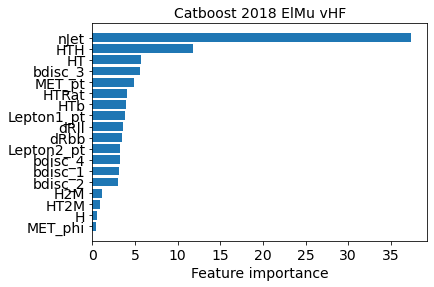

In [24]:
plot_feature_importances(models_cpu["catboost"].get_feature_importance(), TRAIN_FEATURES, 
                         title=f"Catboost {era} {channel} {mode}")

/tmp/nmangane/ipykernel_1353/1013090998.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  yy = np.arange(len(f_imps)).astype(np.int)


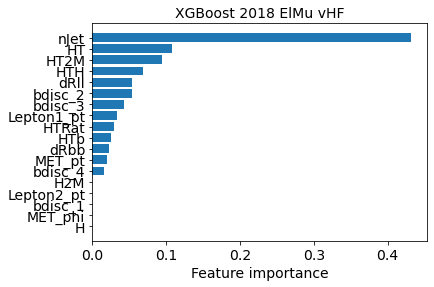

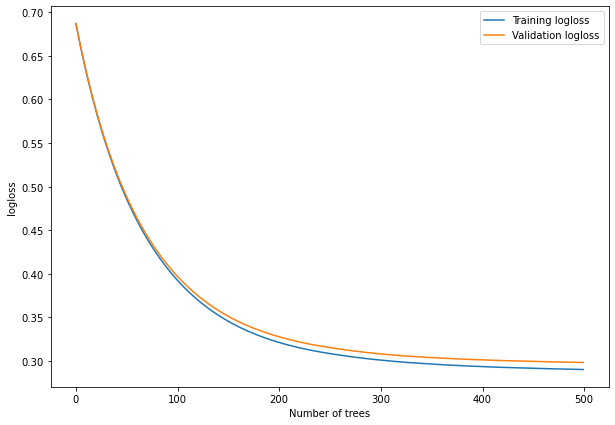

In [25]:
plot_feature_importances(models_cpu["xgboost"].feature_importances_, TRAIN_FEATURES, 
                         title=f"XGBoost {era} {channel} {mode}")
plot_xgboost_validation(models_cpu["xgboost"]) #model.evals_result()

In [26]:
#help(models_cpu["xgboost"].evals_result)
#results

In [27]:
preferred = "catboost"
if preferred == "catboost":
    w_test = w_test_cb
elif preferred == "xgboost":
    w_test = w_test_xgb
print(mode, preferred)
if mode == "vLF":
    model_vLF = models_cpu[preferred]
    print(roc_auc_score(y_test, model_vLF.predict_proba(X_test)[:, 1], sample_weight=w_test))
if mode == "vHF":
    model_vHF = models_cpu[preferred]
    print(roc_auc_score(y_test, model_vHF.predict_proba(X_test)[:, 1], sample_weight=w_test))
if mode == "nested_layer1":
    model_nested_layer1 = models_cpu[preferred]
    print(roc_auc_score(y_test, model_nested_layer1.predict_proba(X_test)[:, 1], sample_weight=w_test))
if mode == "nested_layer2":
    model_nested_layer2 = models_cpu[preferred]
    print(roc_auc_score(y_test, model_nested_layer2.predict_proba(X_test)[:, 1], sample_weight=w_test))
print(model_vLF, model_vHF,  model_nested_layer1,  model_nested_layer2)

if preferred == "catboost":
    models_cpu[preferred].save_model(f"{preferred}_{mode}",
                                     format="cbm",
                                     export_parameters=None,
                                     pool=None
                                    )
if preferred == "xgboost":
    models_cpu[preferred].save_model(f"{preferred}_{mode}_{era}_{channel}.json")
with open(f"{preferred}_{mode}.inputs", "w") as fi:
    for variable in TRAIN_FEATURES:
        fi.write(variable)

vHF catboost
0.7903748336362635
None <catboost.core.CatBoostClassifier object at 0x7f1bfea485b0> None None


In [28]:
if model_vLF and model_vHF:
    if hasattr(model_vLF, "feature_importances_"):
        fi1 = model_vLF.feature_importances_
    elif hasattr(model_vLF, "get_feature_importance"):
        fi1 = model_vLF.get_feature_importance()
        
    if hasattr(model_vHF, "feature_importances_"):
        fi2 = model_vHF.feature_importances_
    elif hasattr(model_vHF, "get_feature_importance"):
        fi2 = model_vHF.get_feature_importance()
        
    plot_feature_importances_2d(fi1, TRAIN_FEATURES, 
                                fi2, TRAIN_FEATURES,
                                "tttt vs ttlight feature importance", 
                                "tttt vs ttbb feature importance",
                                title=preferred)

In [29]:
#### TRY PROCESSING ALL THE DATASETS ####

In [52]:
class SimplePlotter(processor.ProcessorABC):
    def __init__(self, channel: str, named_models_features: Any = None, mode = None):
        self.channel = channel
        self.named_models_features = named_models_features
        self.mode = mode

    def process(self, events: Any) -> Any:
        # Multidimensional histograms are super dangerous... and super fun!!!!
        # This might be about 2GB if RAM for the full tttt analysis 50datasets * 50systematics * 10channels(lets do trilepton for funsies)
        # * 5btags * 10njets * 10leadleppt * 10subleadleppt * 10HTbins
        h = hist.Hist( 
            hist.axis.StrCategory([], name="era", growth=True),
            hist.axis.StrCategory([], name="dataset", growth=True),
            hist.axis.StrCategory([], name="systematic", growth=True),
            hist.axis.StrCategory(
                [], name="channel", label="lepton channel", growth=True
            ),
            hist.axis.StrCategory(
                ["vLF", "vHF", "nested_layer1", "nested_layer2"], name="mva_ver", label="MVA version", growth=False
            ),
            hist.axis.Regular(
                4,
                0,
                4,
                name="nbtag",
                label="$N_{btag}$",
                underflow=False,
                overflow=True,
            ),
            hist.axis.Regular(
                10, 2, 12, name="njet", label="$N_{jet}$", underflow=True, overflow=True
            ),
            hist.axis.Variable(
                [300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1500, 2000],
                name="HT",
                label=r"$H_{T}$",
            ),
            hist.axis.Variable(
                [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                name="mva",
                label=r"MVA score",
            ),
            hist.storage.Weight(),
        )        
        dataset = events.metadata["dataset"]
        era = events.metadata.get("era", None)
        is_mc = events.metadata.get("is_mc", None)
        train_test = events.metadata.get("train_test", None)
        
        train_bound = 500
        train_mask = events.dsid1k < train_bound
        renorm = dict()
        #More efficient to only get_features for scale systematics, but... quick and dirty
        for syst in ["nom"]:
            this_wgt = getattr(events, f"wgt___{syst}")
            #multiplicative weight to scale it back up to 'nominal' size
            print("the type of mode is ", self.mode)
            if self.mode is None:
                if train_test is not None:
                    raise ValueError("mode is set to None but sample is marked as a train_test split")
                fltr = None
                renorm[syst] = 1
            elif self.mode == "train":
                if train_test is None:
                    raise ValueError("mode is set to train but sample is not marked as a train_test split")
                fltr = lambda e: e.dsid1k < train_bound
                print("train", len(fltr(events)))
                renorm[syst] = np.sum(this_wgt) / np.sum(this_wgt[train_mask])
            elif self.mode == "test":
                if train_test is None:
                    raise ValueError("mode is set to test but sample is not marked as a train_test split")
                fltr = lambda e: e.dsid1k >= train_bound
                print("test", len(fltr(events)))
                renorm[syst] = np.sum(this_wgt) / np.sum(this_wgt[~train_mask])
            #non-train_renorm[syst] = np.sum(this_wgt) / np.sum(this_wgt[~train_mask])
            # = np.sum(this_wgt) / (np.sum(this_wgt) - np.sum(this_wgt[train_mask]))
            # = train_renorm[syst] / 
            else:
                raise ValueError("That just can't be!")
            
            
            #models_features = [(model_nested_layer1, LAYER1)]
            variables = get_features(events, 
                                 remove_negative_weights=False, # DO NOT DO IT
                                 normalize_weights=False, # NEGATORY
                                 scale_systematic="nom", # FIXME 
                                 wgt_systematic=syst,
                                 is_mc=is_mc,
                                 e_filter=fltr,
                                 named_models_features = self.named_models_features,
                                )
            
            if variables["wgt"] is not None:
                print("norm:", renorm[syst])
                variables["wgt"] = renorm[syst] * variables["wgt"]
            for name, model, features in self.named_models_features:
                h.fill(era=era, 
                       dataset=dataset, 
                       systematic=syst, 
                       channel=self.channel, 
                       mva_ver=name,
                       nbtag=variables["nMediumDeepJetB"], 
                       njet=variables["nJet"], 
                       HT=variables["HT"], 
                       mva=variables[name],
                       weight=variables["wgt"]
                      )
        return {
            #"sumw": {dataset: ak.sum(events.genWeight) if is_mc else 0},
            # "event_id": {dataset: events.event}, #Need to copy the array somehow, or write it out instead?
            "hist": h,
        }

    def postprocess(self, accumulator: Any) -> Any:
        return accumulator



In [53]:
#from ColumnarFTA.processors.osdilepton import LeptonJetTest as LJT
prefix=f"/eos/home-n/nmangane/analysis/February10_Baseline_{era}/Nano/{channel}/"        
#2018___WJets_SL.root    
if era == "2018":
    suberas = ["A", "B", "C", "D"]
else:
    suberas = ["B", "C", "D", "E", "F"]
train_set = {
      "tttt_train": {
        "files": [
            prefix+f"{era}___tttt.root",
        ],
        "treename": "Events",
        "metadata": {"is_mc": True, "era": era, "train_test": True},
    },
    "ttjj_train": {
        "files": [
            prefix+f"{era}___ttother_{decay}.root" for decay in ["SL_nr", "SL_fr", "SL-GF_fr", 
                                                                 "DL_nr", "DL_fr", "DL-GF_fr"]
        ],
        "treename": "Events",
        "metadata": {"is_mc": True, "era": era, "train_test": True},
    },
    "ttbb_train": {
        "files": [
            prefix+f"{era}___ttbb_{decay}.root" for decay in ["SL_nr", "SL_fr", "SL-GF_fr", 
                                                                 "DL_nr", "DL_fr", "DL-GF_fr"]
        ],
        "treename": "Events",
        "metadata": {"is_mc": True, "era": era, "train_test": True},
    },
} 
test_set = {
      "tttt": {
        "files": [
            prefix+f"{era}___tttt.root",
        ],
        "treename": "Events",
        "metadata": {"is_mc": True, "era": era, "train_test": True},
    },
    "ttjj": {
        "files": [
            prefix+f"{era}___ttother_{decay}.root" for decay in ["SL_nr", "SL_fr", "SL-GF_fr", 
                                                                 "DL_nr", "DL_fr", "DL-GF_fr"]
        ],
        "treename": "Events",
        "metadata": {"is_mc": True, "era": era, "train_test": True},
    },
    "ttbb": {
        "files": [
            prefix+f"{era}___ttbb_{decay}.root" for decay in ["SL_nr", "SL_fr", "SL-GF_fr", 
                                                                 "DL_nr", "DL_fr", "DL-GF_fr"]
        ],
        "treename": "Events",
        "metadata": {"is_mc": True, "era": era, "train_test": True},
    },
}
fileset = {
    f"{channel}": {
        "files": [
            prefix+f"{era}___{channel}_{subera}.root" for subera in suberas
        ],
        "treename": "Events",
        "metadata": {"is_mc": False, "era": era},
    },
    "DY": {
        "files": [
            #prefix+f"{era}___DYJets_DL-HT100.root",
            prefix+f"{era}___DYJets_DL-HT200.root",
            prefix+f"{era}___DYJets_DL-HT400.root",
            prefix+f"{era}___DYJets_DL-HT600.root",
            prefix+f"{era}___DYJets_DL-HT800.root",
            prefix+f"{era}___DYJets_DL-HT1200.root",
            prefix+f"{era}___DYJets_DL-HT2500.root",
        ],
        "treename": "Events",
        "metadata": {"is_mc": True, "era": era, "train": None},
    },
    "WJets": {
        "files": [
            #prefix+f"{era}___WJets_SL-HT100.root",
            #prefix+f"{era}___WJets_SL-HT200.root",
            prefix+f"{era}___WJets_SL-HT400.root",
            prefix+f"{era}___WJets_SL-HT600.root",
            prefix+f"{era}___WJets_SL-HT800.root",
            prefix+f"{era}___WJets_SL-HT1200.root",
            prefix+f"{era}___WJets_SL-HT2500.root",
        ],
        "treename": "Events",
        "metadata": {"is_mc": True, "era": era, "train": None},
    },
    "Diboson": {
        "files": [
            prefix+f"{era}___WW.root",
            prefix+f"{era}___WZ.root",
            prefix+f"{era}___ZZ.root",
        ],
        "treename": "Events",
        "metadata": {"is_mc": True, "era": era, "train": None},
    },
    "ttrare": {
        "files": [
            prefix+f"{era}___tttJ.root",
            prefix+f"{era}___tttW.root",
            prefix+f"{era}___ttWW.root",
            prefix+f"{era}___ttWZ.root",
            prefix+f"{era}___ttWH.root",
            prefix+f"{era}___ttZH.root",
            prefix+f"{era}___ttZZ.root",
            prefix+f"{era}___ttHH.root",
        ],
        "treename": "Events",
        "metadata": {"is_mc": True, "era": era, "train": None},
    },
    "ttVJets": {
        "files": [
            prefix+f"{era}___ttZJets.root",
            prefix+f"{era}___ttWJets.root",
        ],
        "treename": "Events",
        "metadata": {"is_mc": True, "era": era, "train": None},
    },
    "ttH": {
        "files": [
            prefix+f"{era}___ttH_DL-bb.root",
            prefix+f"{era}___ttH_SL-bb.root",
        ],
        "treename": "Events",
        "metadata": {"is_mc": True, "era": era, "train": None},
    },
    "ST": {
        "files": [
            prefix+f"{era}___ST_tbarW-NoFHad.root",
            prefix+f"{era}___ST_tW-NoFHad.root",
        ],
        "treename": "Events",
        "metadata": {"is_mc": True, "era": era, "train": None},
    },
}

In [56]:

# https://github.com/scikit-hep/uproot4/issues/122
uproot.open.defaults["xrootd_handler"] = uproot.source.xrootd.MultithreadedXRootDSource
iterative_run = processor.Runner(
    # executor = processor.FuturesExecutor(compression=None),
    executor=processor.IterativeExecutor(compression=None),
    metadata_cache={},
    schema=BaseSchema,
    maxchunks=None,
)
nmf = []
if model_vLF is not None:
    nmf.append(("vLF", model_vLF, TRAIN_vLF))
if model_vHF is not None:
    nmf.append(("vHF", model_vHF, TRAIN_vHF))
if model_nested_layer1 is not None:
    nmf.append(("nested_layer1", model_nested_layer1, TRAIN_nested_layer1))
if model_nested_layer2 is not None:
    nmf.append(("nested_layer2", model_nested_layer2, TRAIN_nested_layer2))
out1 = iterative_run(
    fileset,
    treename="Events",
    processor_instance=SimplePlotter(channel=channel, 
                                     named_models_features=nmf,
                                     mode=None,
                                    ),
)
out2 = iterative_run(
    train_set,
    treename="Events",
    processor_instance=SimplePlotter(channel=channel, 
                                     named_models_features=nmf,
                                     mode="train"
                                    ),
)
out3 = iterative_run(
    test_set,
    treename="Events",
    processor_instance=SimplePlotter(channel=channel, 
                                     named_models_features=nmf,
                                     mode="test"
                                    ),
)
out = dict()
for k, v in out1.items():
    out[k] = v
for k, v in out2.items():
    out[k] += v
for k, v in out3.items():
    out[k] += v

Preprocessing:   0%|          | 0/32 [00:00<?, ?file/s]

Processing:   0%|          | 0/33 [00:00<?, ?chunk/s]

the type of mode is  None
mean dsid1k 495.5217391304348
norm: 1
the type of mode is  None
mean dsid1k 502.0606531881804
norm: 1
the type of mode is  None
mean dsid1k 486.6096837944664
norm: 1
the type of mode is  None
mean dsid1k 498.11809785512554
norm: 1
the type of mode is  None
mean dsid1k 498.7761111875602
norm: 1
the type of mode is  None
mean dsid1k 497.3728535980149
norm: 1
the type of mode is  None
mean dsid1k 498.3909728901713
norm: 1
the type of mode is  None
mean dsid1k 458.58782201405154
norm: 1
the type of mode is  None
mean dsid1k 444.25378151260503
norm: 1
the type of mode is  None
mean dsid1k 481.72402938090244
norm: 1
the type of mode is  None
mean dsid1k 492.119698397738
norm: 1
the type of mode is  None
mean dsid1k 482.258064516129
norm: 1
the type of mode is  None
mean dsid1k 489.99821548070486
norm: 1
the type of mode is  None
mean dsid1k 496.34988797610157
norm: 1
the type of mode is  None
mean dsid1k 497.3545119705341
norm: 1
the type of mode is  None
mean dsid1

No objects info loaded


the type of mode is  None
mean dsid1k 241.0
norm: 1
the type of mode is  None
mean dsid1k 918.0
norm: 1
the type of mode is  None
mean dsid1k 407.5625
norm: 1
the type of mode is  None
mean dsid1k 441.0882352941176
norm: 1
the type of mode is  None
mean dsid1k 410.10526315789474
norm: 1
the type of mode is  None
mean dsid1k 457.38461538461536
norm: 1
the type of mode is  None
mean dsid1k 595.0
norm: 1
the type of mode is  None
mean dsid1k 530.5
norm: 1
the type of mode is  None
mean dsid1k 400.52941176470586
norm: 1
the type of mode is  None
mean dsid1k 464.0065359477124
norm: 1
the type of mode is  None
mean dsid1k 505.71974522292993
norm: 1
the type of mode is  None
mean dsid1k 501.8378378378378
norm: 1
the type of mode is  None
mean dsid1k nan
norm: 1


No objects info loaded


the type of mode is  None
mean dsid1k 500.541954887218
the type of mode is  None
mean dsid1k 501.11267605633805
the type of mode is  None
mean dsid1k 469.55927835051546
the type of mode is  None
mean dsid1k 497.23658872077027


Preprocessing:   0%|          | 0/13 [00:00<?, ?file/s]

Processing:   0%|          | 0/20 [00:00<?, ?chunk/s]

the type of mode is  train
train 24965
mean dsid1k 248.7634570220761
norm: 2.0032344067666337
the type of mode is  train
train 3017
mean dsid1k 246.10687022900763
norm: 2.0003431735323143
the type of mode is  train
train 1081
mean dsid1k 248.4466501240695
norm: 2.0063033154224104
the type of mode is  train
train 229
mean dsid1k 224.7872340425532
norm: 1.894376342774374
the type of mode is  train
train 25
mean dsid1k 268.625
norm: 2.2315339795164624
the type of mode is  train
train 67
mean dsid1k 292.06666666666666
norm: 1.9328608023429026
the type of mode is  train
train 106304
mean dsid1k 250.94285019455253
norm: 2.0005789159025467
the type of mode is  train
train 106304
mean dsid1k 248.9212788259958
norm: 1.9969293579492438
the type of mode is  train
train 106304
mean dsid1k 249.22240366908724
norm: 1.999794956126359
the type of mode is  train
train 106304
mean dsid1k 249.467045533301
norm: 2.005663406795884
the type of mode is  train
train 106304
mean dsid1k 250.5822522771184
norm: 

Processing:   0%|          | 0/20 [00:00<?, ?chunk/s]

the type of mode is  test
test 24965
mean dsid1k 751.0355108241549
norm: 1.9967760208932053
the type of mode is  test
test 3017
mean dsid1k 748.9834123222748
norm: 1.9996569441953578
the type of mode is  test
test 1081
mean dsid1k 760.9683698296838
norm: 1.9937361674896559
the type of mode is  test
test 229
mean dsid1k 767.7415730337078
norm: 2.1180975526454326
the type of mode is  test
test 25
mean dsid1k 668.7272727272727
norm: 1.8119954598350831
the type of mode is  test
test 67
mean dsid1k 797.2777777777778
norm: 2.071971292489164
the type of mode is  test
test 106304
mean dsid1k 749.335967416278
norm: 1.999421419047168
the type of mode is  test
test 106304
mean dsid1k 748.8684100272327
norm: 2.003080099935137
the type of mode is  test
test 106304
mean dsid1k 748.1443639908097
norm: 2.0002050859252534
the type of mode is  test
test 106304
mean dsid1k 748.9287178952491
norm: 1.9943684867545026
the type of mode is  test
test 106304
mean dsid1k 748.4944316837197
norm: 1.99632760248181

/afs/cern.ch/user/n/nmangane/.local/lib/python3.9/site-packages/boost_histogram/_internal/hist.py:872: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f1ba9e71a00>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f1baa3a8e50>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f1bfda69130>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f1baa5e0610>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f1ba9911250>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f1bfd98e2e

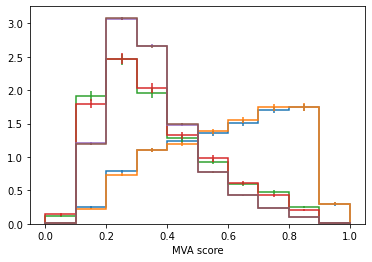

In [57]:
test = out["hist"][{"era":"2018", "systematic": "nom", "channel":"ElMu"}]
test[["tttt", "tttt_train", "ttbb", "ttbb_train", "ttjj", "ttjj_train"], 
     ['vHF'], 
     ...].project("mva", "dataset").plot(density=True)

In [58]:
diff = test["tttt", "vHF", ...].project("mva").to_numpy()[0] - test["tttt_train", "vHF", ...].project("mva").to_numpy()[0]
print(diff)

[ 4.26054198e-05  2.79952107e-02  5.37773629e-02 -9.67943349e-03
  5.26123802e-02 -5.29842926e-02 -7.93066286e-02 -6.80532573e-02
 -2.54256195e-02 -8.07370769e-03]


In [59]:
#OLDER STUFF#

In [160]:
print("CATBOOST AUC")
print(roc_auc_score(y_test, clf_cb.predict_proba(X_test)[:, 1], sample_weight=w_test))
print("XGB AUC")
print(roc_auc_score(y_test, clf_xgb.predict_proba(X_test)[:, 1], sample_weight=w_test))

CATBOOST AUC
0.8539057567732808
XGB AUC
0.6133516187703523


/tmp/nmangane/ipykernel_25064/2498021274.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  yy = np.arange(len(f_imps)).astype(np.int)


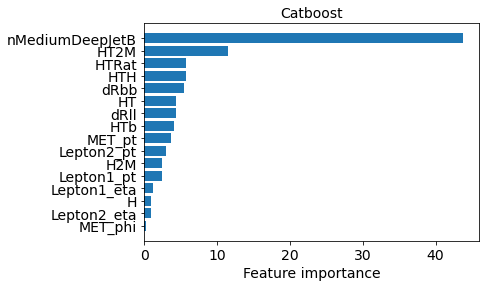

In [161]:
cb_fi = clf_cb.get_feature_importance()
plot_feature_importances(cb_fi, TRAIN_FEATURES, title="Catboost")
#for feat, imp in sorted(zip(TRAIN_FEATURES, cb_fi), key=lambda tup: tup[1], reverse=True):
#    print(f"{feat:20s} \t {imp}")

/tmp/nmangane/ipykernel_25064/2498021274.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  yy = np.arange(len(f_imps)).astype(np.int)


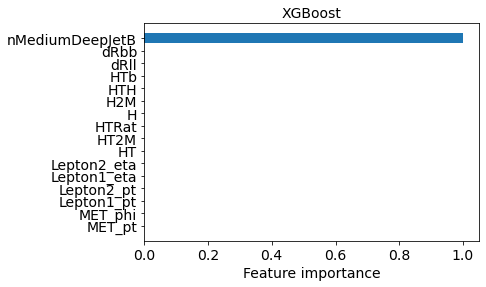

In [162]:
xgb_fi = clf_xgb.feature_importances_
plot_feature_importances(xgb_fi, TRAIN_FEATURES, title="XGBoost")
#for feat, imp in sorted(zip(TRAIN_FEATURES, xgb_fi), key=lambda tup: tup[1], reverse=True):
#    print(f"{feat:20s} \t {imp}")

In [163]:
#for field in events.fields:
#    print(f"{field:35s}\t\t{(np.mean(ak.num(field, axis=0)))}\t{(np.var(ak.num(field, axis=0)))}")

<Array [4, 12, 7, 6, 8, 10, ... 5, 2, 6, 8, 7] type='10000 * int64'>

In [33]:
all_fields = events.fields
print(len(all_fields))
wgts = [all_fields.pop(all_fields.index(f)) for f in all_fields if f.startswith("wgt_")]

print(len(wgts))
print(len(all_fields))

263
34
229
['wgt___nom', 'wgt___OSDL_2018_jesTotalDown', 'wgt___OSDL_2018_HEMDown', 'wgt___OSDL_2018_pileupDown', 'wgt___OSDL_2018_jerDown', 'wgt___OSDL_RunII_btagSF_shape_hfDown', 'wgt___OSDL_2018_btagSF_shape_hfstats1Down', 'wgt___OSDL_2018_btagSF_shape_hfstats2Down', 'wgt___OSDL_RunII_btagSF_shape_cferr1Down', 'wgt___OSDL_RunII_btagSF_shape_cferr2Down', 'wgt___OSDL_RunII_btagSF_shape_lfDown', 'wgt___OSDL_2018_btagSF_shape_lfstats1Down', 'wgt___OSDL_2018_btagSF_shape_lfstats2Down', 'wgt___OSDL_RunII_ISRUp', 'wgt___OSDL_RunII_FSRUp', 'wgt___OSDL_RunII_muFNomRUp', 'wgt___OSDL_RunII_muRNomFUp', 'wgt___OSDL_RunII_muRFcorrelatedDown', 'wgt___OSDL_RunII_pdf2', 'wgt___OSDL_RunII_pdf4', 'wgt___OSDL_RunII_pdf6', 'wgt___OSDL_RunII_pdf8', 'wgt___OSDL_RunII_pdf10', 'wgt___OSDL_RunII_pdf12', 'wgt___OSDL_RunII_pdf14', 'wgt___OSDL_RunII_pdf16', 'wgt___OSDL_RunII_pdf18', 'wgt___OSDL_RunII_pdf20', 'wgt___OSDL_RunII_pdf22', 'wgt___OSDL_RunII_pdf24', 'wgt___OSDL_RunII_pdf26', 'wgt___OSDL_RunII_pdf28', 